In [1]:
# Find optimal radius of 8dim sphere that recapitulates the number of cells averaged over all the 8 center bins

In [2]:
!pwd

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/Optimization8DimSphere


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as spstats
from scipy import cluster as spcluster
from matplotlib import lines as pltlines
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

# import mouskatools

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
device = io.LocalStagingIO(control)
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
df = device.load_step_manifest("preprocessing")
print(df.shape)

(202847, 1290)


In [185]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [186]:
data = []
for sm in control.get_shape_modes():
    space.set_active_shape_mode(sm, digitize=True)
    space.set_active_map_point_index(control.get_center_map_point_index())
    CellIds = space.get_active_cellids()
    serie = df.loc[CellIds, ["structure_name"]].groupby("structure_name").size()
    serie.name = sm
    data.append(serie)
df_agg = pd.DataFrame(data).T
df_agg = df_agg.reindex(control.get_gene_names())
df_agg = pd.DataFrame(df_agg.mean(axis=1), columns=["AvgNumberOfCells"])
print(df_agg.sum())
df_agg

AvgNumberOfCells    35251.75
dtype: float64


,AvgNumberOfCells
structure_name,
FBL,1624.250
NPM1,1940.625
SON,507.375
SMC1A,456.875
HIST1H2BJ,2772.750
LMNB1,2335.000
NUP153,3033.500
SEC61B,969.625
ATP2A2,1917.375


In [174]:
dist = space.shape_modes.values.copy()
dist -= dist.mean(axis=0, keepdims=True)
dist /= dist.std(axis=0, keepdims=True)
dist = np.sqrt(np.power(dist, 2).sum(axis=1))
df_sm = pd.DataFrame({"Distance": dist}, index=space.shape_modes.index)

In [175]:
def get_sigma_df(sigmas=np.linspace(1.5, 2.5, 16)):#(0.5, 4.0, 16)):#
    data = []
    for s in sigmas:
        CellIds = df_sm.loc[df_sm.Distance<s].index
        serie = df.loc[CellIds, ["structure_name"]].groupby("structure_name").size()
        serie.name = f"Sigma={s:.2f}"
        data.append(serie)
    df_sigma = pd.DataFrame(data).T
    df_sigma = df_sigma.reindex(control.get_gene_names())
    df_sigma = df_sigma.replace(np.nan, 0)
    return df_sigma

df_sigma = get_sigma_df()
df_sigma

,Sigma=1.50,Sigma=1.57,Sigma=1.63,Sigma=1.70,Sigma=1.77,Sigma=1.83,Sigma=1.90,Sigma=1.97,Sigma=2.03,Sigma=2.10,Sigma=2.17,Sigma=2.23,Sigma=2.30,Sigma=2.37,Sigma=2.43,Sigma=2.50
structure_name,,,,,,,,,,,,,,,,
FBL,241,305,405,508,636,785,962,1139,1342,1556,1775,1983,2224,2509,2761,3008
NPM1,261,352,459,592,756,925,1102,1315,1544,1822,2099,2374,2702,3017,3339,3670
SON,35,57,79,100,126,156,203,247,303,369,447,543,642,750,855,965
SMC1A,77,99,131,175,206,261,319,383,460,550,642,728,806,897,991,1103
HIST1H2BJ,435,589,743,969,1185,1447,1730,2085,2470,2879,3317,3812,4292,4876,5442,6024
LMNB1,453,594,756,926,1139,1399,1691,2005,2316,2718,3087,3490,3911,4388,4848,5315
NUP153,520,704,897,1150,1415,1709,2026,2400,2839,3295,3798,4299,4837,5371,5939,6514
SEC61B,108,142,189,243,302,371,442,534,642,747,852,979,1113,1249,1420,1602
ATP2A2,320,420,555,709,906,1118,1362,1658,1963,2305,2653,3048,3436,3837,4233,4627


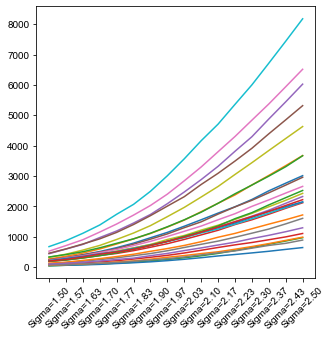

In [176]:
fog, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(df_sigma.T)
ax.tick_params(axis="x", labelrotation=45)
plt.show()

In [177]:
for col in df_sigma.columns:
    df_sigma[col] = (df_sigma[col]-df_agg.AvgNumberOfCells)**2
df_sigma = df_sigma.T
df_sigma = np.sqrt(df_sigma.sum(axis=1))
df_sigma

Sigma=1.50    6930.649174
Sigma=1.57    6510.841552
Sigma=1.63    6009.941199
Sigma=1.70    5407.194949
Sigma=1.77    4725.282792
Sigma=1.83    3976.475446
Sigma=1.90    3109.846695
Sigma=1.97    2131.910404
Sigma=2.03    1140.092636
Sigma=2.10     802.901905
Sigma=2.17    1741.479032
Sigma=2.23    3029.848011
Sigma=2.30    4390.665664
Sigma=2.37    5878.297774
Sigma=2.43    7384.332144
Sigma=2.50    8927.350487
dtype: float64

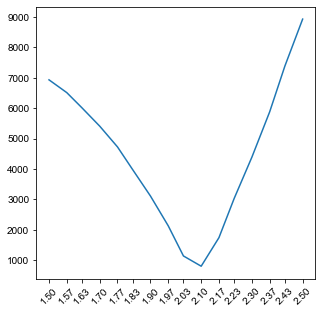

In [178]:
x = [float(v.split("=")[-1]) for v in df_sigma.index]
y = df_sigma.values
fog, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(x, y)
ax.set_xticks(x)
ax.tick_params(axis="x", labelrotation=45)
plt.show()

In [179]:
for index, row in df_agg.iterrows():
    n = len(df.loc[df.structure_name==index])
    df_agg.at[index, "AvgNumberOfCells"] /= n
df_agg

,AvgNumberOfCells
structure_name,
FBL,0.163172
NPM1,0.164010
SON,0.178710
SMC1A,0.200824
HIST1H2BJ,0.183719
LMNB1,0.196797
NUP153,0.180369
SEC61B,0.151287
ATP2A2,0.197520


In [180]:
df_sigma = get_sigma_df()
for index, row in df_sigma.iterrows():
    n = len(df.loc[df.structure_name==index])
    df_sigma.loc[index, :] /= n
df_sigma

,Sigma=1.50,Sigma=1.57,Sigma=1.63,Sigma=1.70,Sigma=1.77,Sigma=1.83,Sigma=1.90,Sigma=1.97,Sigma=2.03,Sigma=2.10,Sigma=2.17,Sigma=2.23,Sigma=2.30,Sigma=2.37,Sigma=2.43,Sigma=2.50
structure_name,,,,,,,,,,,,,,,,
FBL,0.024209,0.030638,0.040683,0.051030,0.063887,0.078855,0.096635,0.114415,0.134807,0.156303,0.178302,0.199196,0.223405,0.252034,0.277348,0.302160
NPM1,0.022068,0.029762,0.038810,0.050055,0.063922,0.078211,0.093177,0.111186,0.130549,0.154054,0.177475,0.200727,0.228460,0.255094,0.282320,0.310307
SON,0.012337,0.020092,0.027846,0.035249,0.044413,0.054988,0.071554,0.087064,0.106803,0.130067,0.157561,0.191399,0.226295,0.264364,0.301375,0.340148
SMC1A,0.033846,0.043516,0.057582,0.076923,0.090549,0.114725,0.140220,0.168352,0.202198,0.241758,0.282198,0.320000,0.354286,0.394286,0.435604,0.484835
HIST1H2BJ,0.028825,0.039030,0.049235,0.064210,0.078524,0.095885,0.114638,0.138162,0.163674,0.190776,0.219800,0.252601,0.284408,0.323106,0.360612,0.399178
LMNB1,0.038180,0.050063,0.063717,0.078045,0.095997,0.117910,0.142520,0.168984,0.195196,0.229077,0.260177,0.294142,0.329625,0.369827,0.408597,0.447956
NUP153,0.030917,0.041857,0.053333,0.068375,0.084131,0.101611,0.120459,0.142696,0.168797,0.195909,0.225816,0.255604,0.287591,0.319341,0.353113,0.387300
SEC61B,0.016849,0.022153,0.029485,0.037910,0.047114,0.057878,0.068955,0.083307,0.100156,0.116537,0.132917,0.152730,0.173635,0.194852,0.221529,0.249922
ATP2A2,0.032969,0.043272,0.057181,0.073048,0.093344,0.115186,0.140326,0.170822,0.202246,0.237482,0.273336,0.314033,0.354008,0.395322,0.436122,0.476715


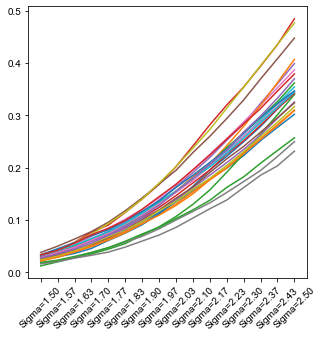

In [181]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(df_sigma.T)
ax.tick_params(axis="x", labelrotation=45)
plt.show()

In [182]:
for col in df_sigma.columns:
    df_sigma[col] = (df_sigma[col]-df_agg.AvgNumberOfCells)**2
df_sigma = df_sigma.T
df_sigma = np.sqrt(df_sigma.sum(axis=1))
df_sigma

Sigma=1.50    0.735688
Sigma=1.57    0.694330
Sigma=1.63    0.643436
Sigma=1.70    0.583146
Sigma=1.77    0.517093
Sigma=1.83    0.441048
Sigma=1.90    0.350780
Sigma=1.97    0.254094
Sigma=2.03    0.157112
Sigma=2.10    0.107643
Sigma=2.17    0.178778
Sigma=2.23    0.302918
Sigma=2.30    0.442244
Sigma=2.37    0.595048
Sigma=2.43    0.752510
Sigma=2.50    0.916792
dtype: float64

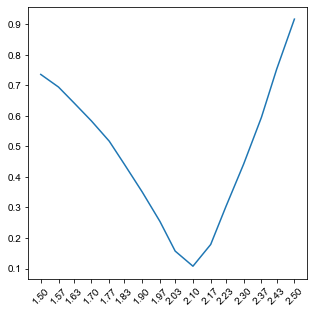

In [183]:
x = [float(v.split("=")[-1]) for v in df_sigma.index]
y = df_sigma.values
fog, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(x, y)
ax.set_xticks(x)
ax.tick_params(axis="x", labelrotation=45)
plt.show()

In [184]:
df_sigma = get_sigma_df(sigmas=[2.10])
df_sigma

,Sigma=2.10
structure_name,
FBL,1556
NPM1,1822
SON,369
SMC1A,550
HIST1H2BJ,2879
LMNB1,2718
NUP153,3295
SEC61B,747
ATP2A2,2305


In [158]:
df_sigma.sum()

Sigma=2.10    35633
dtype: int64